# Plot Segmentation in Agriculture Using Computer Vision Techniques: A Scientific Approach

In the realm of precision agriculture, plot segmentation plays a pivotal role in crop management and yield optimization. This Jupyter Notebook presents a comprehensive workflow for segmenting agricultural plots by harnessing the power of computer vision and image processing techniques. We demonstrate the integration of image manipulation, filtering, and augmentation to extract meaningful insights from agricultural imagery.


# Section 1: Setup and Data Preparation


## Initial Imports

Here we import necessary libraries such as OpenCV, NumPy, and Matplotlib. These libraries provide us with the tools required for image manipulation and visualization.


In [ ]:
!pip install tensorflow -q

In [ ]:
import os
import sys
import math
import random
import time
import subprocess
import psutil
import torch

import cv2                          as cv
import keras                        as K
import numpy                        as np
import tensorflow                   as tf
import matplotlib.pyplot            as plt

from PIL                            import Image, ImageTk
from google.colab                   import drive
from scipy.ndimage                  import convolve

from tensorflow                     import data as tf_data
from keras                          import optimizers, callbacks, Model
from keras.models                   import Sequential
from keras.layers                   import Conv2D, Input, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, SeparableConv2D, Conv2DTranspose, UpSampling2D, add

## Drive Mounting

Here we mount the Google Drive to access the dataset.

In [ ]:
drive.mount('/content/drive')

## Image Data Manager Class

The `ImageDataManager` class is designed to simplify the handling of image datasets. It loads images from specified directories, processes them into a usable format, and stores them for further analysis.

In [ ]:
class ImageDataManager:
    """
    A class used to manage image data for processing and analysis.

    Attributes
    ----------
    objects : dict
        A dictionary to store processed image data with mask IDs as keys.
    base_masks_path : str
        Path to the directory containing mask images.
    base_inputs_path : str
        Path to the directory containing input images.

    Methods
    -------
    process_images()
        Processes all images found in the base paths and populates the objects dictionary.
    process_input_folder(input_folder_path)
        Processes all images within a given input folder path and returns a list of images.
    """

    def __init__(self, base_masks_path, base_inputs_path):
        """
        Constructs all the necessary attributes for the ImageDataManager object.

        Parameters
        ----------
        base_masks_path : str
            Path to the directory containing mask images.
        base_inputs_path : str
            Path to the directory containing input images.
        """
        self.objects = {}
        self.base_masks_path = base_masks_path
        self.base_inputs_path = base_inputs_path
        self.process_images()

    @staticmethod
    def load_image(image_path, flags=cv.IMREAD_COLOR):
        """
        Loads an image from a specified path.

        Parameters
        ----------
        image_path : str
            Path to the image file to be loaded.
        flags : int
            Flags for image color format to be read.

        Returns
        -------
        ndarray
            The image loaded into memory.
        """
        return cv.imread(image_path, flags)

    @staticmethod
    def split_channels(image_path):
        """
        Splits the channels of an image at the given path.

        Parameters
        ----------
        image_path : str
            Path to the image file.

        Returns
        -------
        list
            A list containing the channels of the image.
        """
        image = cv.imread(image_path, cv.IMREAD_UNCHANGED)
        channels = cv.split(image)
        if len(channels) == 4:
            return channels[:3]  # Ignore alpha channel
        return channels

    def process_images(self):
        """
        Processes the images found in the base paths and stores them in the objects dictionary.
        """
        for mask_filename in os.listdir(self.base_masks_path):
            if mask_filename.endswith('.png'):
                mask_id = os.path.splitext(mask_filename)[0]
                mask_path = os.path.join(self.base_masks_path, mask_filename)
                mask = self.load_image(mask_path, cv.IMREAD_GRAYSCALE)
                input_folder_path = os.path.join(self.base_inputs_path, mask_id)
                images = self.process_input_folder(input_folder_path)
                self.objects[int(mask_id)] = {
                    'mask': mask,
                    'input': input_folder_path,
                    'images': images
                }

    def process_input_folder(self, input_folder_path):
        """
        Processes all images within the given input folder path.

        Parameters
        ----------
        input_folder_path : str
            Path to the input folder containing image files.

        Returns
        -------
        list
            A list of processed images.
        """
        images = []
        if os.path.isdir(input_folder_path):
            for image_filename in os.listdir(input_folder_path):
                image_path = os.path.join(input_folder_path, image_filename)
                if image_filename.endswith('.png'):
                    channels = self.split_channels(image_path)
                    images.append(np.array(channels))
                elif image_filename.endswith(('.tif', '.tiff')):
                    tif_image = self.load_image(image_path, cv.IMREAD_UNCHANGED)
                    images.append(np.array([tif_image]))
        return images

# Section 2: Visualization Tools


## Visualizer Class
The `Visualizer` class contains methods for displaying images and their channels. It helps us understand the data and the effects of processing steps visually.

In [ ]:
class Visualizer:
    """
    A class used to visualize image data.

    Methods
    -------
    visualize_objects(objects)
        Visualizes the processed image data from the objects dictionary.
    calculate_subplots(image_sets)
        Calculates the number of subplots needed for the visualization based on the image sets.
    display_images(num_rows, num_columns, image_sets)
        Displays images in a grid layout as subplots.
    """

    @staticmethod
    def visualize_objects(objects):
        """
        Visualizes the processed image data from the objects dictionary.

        Parameters
        ----------
        objects : dict
            Dictionary containing processed image data to visualize.
        """
        for mask_id, data in objects.items():
            mask = data['mask']
            image_sets = data['images']
            num_subplots = Visualizer.calculate_subplots(image_sets)
            num_columns = min(num_subplots, 4)
            num_rows = math.ceil(num_subplots / num_columns)
            plt.figure(figsize=(4 * num_columns, 3 * num_rows))
            plt.subplot(num_rows, num_columns, 1)
            plt.title(f"Mask {mask_id}")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            Visualizer.display_images(num_rows, num_columns, image_sets)
            plt.tight_layout()
            plt.show()

    @staticmethod
    def calculate_subplots(image_sets):
        """
        Calculates the number of subplots needed based on the image sets.

        Parameters
        ----------
        image_sets : list
            A list of image sets, where each image set corresponds to a group of channels.

        Returns
        -------
        int
            The total number of subplots needed.
        """
        return 1 + sum(len(images) for images in image_sets)

    @staticmethod
    def display_images(num_rows, num_columns, image_sets):
        """
        Displays images in a grid layout as subplots.

        Parameters
        ----------
        num_rows : int
            Number of rows in the grid layout.
        num_columns : int
            Number of columns in the grid layout.
        image_sets : list
            A list of image sets to be displayed.
        """
        subplot_idx = 2
        for image_set in image_sets:
            for channel in image_set:
                plt.subplot(num_rows, num_columns, subplot_idx)
                plt.imshow(channel, cmap='gray')
                plt.axis('off')
                title = f"TIFF Image {subplot_idx-1}" if len(image_set) == 1 else f"PNG Ch {subplot_idx-1}"
                plt.title(title)
                subplot_idx += 1

# Section 3: Image Processing Pipeline

## Preprocessing Auxiliary Classes

Here we define a suite of image preprocessing classes that extend `BaseImageProcess`. Each class implements a specific image preprocessing technique, such as rotation, blurring, and thresholding, which are essential for the feature extraction phase of plot segmentation.



In [ ]:
class BaseImageProcess:
    """
    BaseImageProcess: A base class for image processing algorithms.

    This class provides a basic framework for implementing image processing algorithms and is intended to be subclassed.
    Subclasses should implement the `apply` method to perform specific image processing operations on an input image.
    """

    def apply(self, img, mask=None):
        """
        Placeholder for applying an image processing algorithm.

        Args:
            img: The input image to process.

        Returns:
            The processed image.
        """
        pass


class Rotate(BaseImageProcess):
    def __init__(self):
        self.angle = random.choice(list(range(-180, 181, 10)))

    def apply(self, img, mask=None):
        height, width = img.shape[:2]
        rotation_matrix = cv.getRotationMatrix2D((width / 2, height / 2), self.angle, 1)
        return cv.warpAffine(img, rotation_matrix, (width, height)), (
            cv.warpAffine(mask, rotation_matrix, (width, height))
            if mask is not None
            else None
        )


class BilateralFilter(BaseImageProcess):
    """
    BilateralFilter: Applies bilateral filtering to an image to reduce noise while keeping edges sharp.
    """

    def __init__(self, d=9, sigmaColor=75, sigmaSpace=75):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def apply(self, img, mask=None):
        return cv.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace), mask


class Translate(BaseImageProcess):
    """
    Applies translation to an image using random horizontal and vertical shifts.

    Attributes:
        dx (int): Horizontal shift, chosen randomly from a specified range.
        dy (int): Vertical shift, chosen randomly from a specified range.
    """

    def __init__(self):
        self.dx = random.choice([-10, -5, 0, 5, 10])
        self.dy = random.choice([-10, -5, 0, 5, 10])

    def apply(self, img, mask=None):
        translation_matrix = np.float32([[1, 0, self.dx], [0, 1, self.dy]])
        height, width = img.shape[:2]
        return cv.warpAffine(img, translation_matrix, (width, height)), (
            cv.warpAffine(mask, translation_matrix, (width, height))
            if mask is not None
            else None
        )


class Flip(BaseImageProcess):
    """
    Flips an image either horizontally, vertically, or both, based on a randomly selected flip type.

    Attributes:
        flip_type (int): Type of flip to apply; -1 for both axes, 0 for vertical, 1 for horizontal.
    """

    def __init__(self):
        self.flip_type = random.choice([-1, 0, 1])

    def apply(self, img, mask=None):
        return cv.flip(img, self.flip_type), (
            cv.flip(mask, self.flip_type) if mask is not None else None
        )


class BrightnessContrast(BaseImageProcess):
    """
    Adjusts the brightness and contrast of an image using random values.

    Attributes:
        alpha (float): Factor by which the contrast will be adjusted.
        beta (int): Value that will be added to the pixels for brightness adjustment.
    """

    def __init__(self):
        self.alpha = random.uniform(0.5, 1.5)
        self.beta = random.randint(-50, 50)

    def apply(self, img, mask=None):
        return cv.convertScaleAbs(img, alpha=self.alpha, beta=self.beta), mask


class MedianBlur(BaseImageProcess):
    """
    Applies median blurring to an image using a randomly chosen kernel size.

    Attributes:
        kernel_size (int): The size of the kernel used, selected randomly from a set of possible odd sizes.
    """

    def __init__(self):
        self.kernel_size = random.choice([3, 5, 7, 9, 11])

    def apply(self, img, mask=None):
        return cv.medianBlur(img, self.kernel_size), mask


class RandomGaussianBlur(BaseImageProcess):
    """
    Applies Gaussian blur filtering to an image with a randomly chosen kernel size.

    Attributes:
        kernel_size (int): Size of the Gaussian blur kernel, selected randomly.
    """

    def __init__(self):
        self.kernel_size = random.choice([3, 5, 7, 9, 11])

    def apply(self, img, mask=None):
        return cv.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0), mask


class GaussianBlur(BaseImageProcess):
    """
    GaussianBlur: Applies Gaussian blur filtering to an image.

    This class provides an implementation of Gaussian blur filtering, commonly used to reduce image noise and detail.

    Attributes:
        kernel_size (int): Size of the kernel used for the Gaussian filter.
    """

    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def apply(self, img, mask=None):
        return cv.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0), mask


class BinaryThresh(BaseImageProcess):
    """
    BinaryThresh: Applies binary thresholding to an image.

    Binary thresholding converts an image to binary (black and white) based on a threshold value. Pixels above the
    threshold are set to the maximum value, and those below are set to zero.

    Attributes:
        thresh (int): Threshold value.
        max_val (int): Maximum value to use with the threshold.
    """

    def __init__(self, thresh=127, max_val=255):
        self.thresh = thresh
        self.max_val = max_val

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        _, _img = cv.threshold(_img, self.thresh, self.max_val, cv.THRESH_BINARY)
        return _img, mask


class AdaptiveMeanThresh(BaseImageProcess):
    """
    AdaptiveMeanThresh: Applies adaptive mean thresholding to an image.

    Unlike simple thresholding, adaptive thresholding changes the threshold dynamically over the image based on local
    image characteristics.

    Attributes:
        block_size (int): Size of a pixel neighborhood used to calculate the threshold.
        c (int): Constant subtracted from the calculated mean or weighted mean.
    """

    def __init__(self, block_size=11, c=2):
        self.block_size = block_size
        self.c = c

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        return (
            cv.adaptiveThreshold(
                _img,
                255,
                cv.ADAPTIVE_THRESH_MEAN_C,
                cv.THRESH_BINARY,
                self.block_size,
                self.c,
            ),
            mask,
        )


class AdaptiveGaussThresh(BaseImageProcess):
    """
    AdaptiveGaussThresh: Applies adaptive Gaussian thresholding to an image.

    This method uses a weighted sum of neighbourhood values where weights are a Gaussian window, which provides
    a more natural thresholding, especially under varying illumination.

    Attributes:
        block_size (int): Size of a pixel neighborhood used to calculate the threshold.
        c (int): Constant subtracted from the calculated weighted sum.
    """

    def __init__(self, block_size=11, c=2):
        self.block_size = block_size
        self.c = c

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        return (
            cv.adaptiveThreshold(
                _img,
                255,
                cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv.THRESH_BINARY,
                self.block_size,
                self.c,
            ),
            mask,
        )


class OtsuThresh(BaseImageProcess):
    """
    OtsuThresh: Applies Otsu's thresholding to automatically perform histogram shape-based image thresholding.

    This method is useful when the image contains two prominent pixel intensities and calculates an optimal threshold
    separating these two classes so that their combined spread (intra-class variance) is minimal.
    """

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        _, _img = cv.threshold(_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        return _img, mask


class MorphDilate(BaseImageProcess):
    """
    MorphDilate: Applies morphological dilation to an image.

    Dilation increases the white region in the image or size of the foreground object. Commonly used to accentuate
    features.

    Attributes:
        kernel_size (int): Size of the structuring element.
        iterations (int): Number of times dilation is applied.
    """

    def __init__(self, kernel_size=3, iterations=2):
        self.kernel_size = kernel_size
        self.iterations = iterations
        self.kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)

    def apply(self, img, mask=None):
        return cv.dilate(img, self.kernel, iterations=self.iterations), mask


class MorphErode(BaseImageProcess):
    """
    MorphErode: Applies morphological erosion to an image.

    Erosion erodes away the boundaries of the foreground object and is used to diminish the features of an image.

    Attributes:
        kernel_size (int): Size of the structuring element.
        iterations (int): Number of times erosion is applied.
    """

    def __init__(self, kernel_size=3, iterations=2):
        self.kernel_size = kernel_size
        self.iterations = iterations
        self.kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)

    def apply(self, img, mask=None):
        return cv.erode(img, self.kernel, iterations=self.iterations), mask


class LoG(BaseImageProcess):
    """
    LoG: Applies Laplacian of Gaussian filtering to an image.

    This method is used to highlight regions of rapid intensity change and is therefore often used for edge detection.
    First, it applies a Gaussian blur, then computes the Laplacian of the result.

    Attributes:
        sigma (float): Standard deviation of the Gaussian filter.
        size (int): Size of the filter kernel.
    """

    def __init__(self, sigma=2.0, size=None):
        self.sigma = sigma
        self.size = (
            size
            if size is not None
            else int(6 * self.sigma + 1) if self.sigma >= 1 else 7
        )
        if self.size % 2 == 0:
            self.size += 1

    def apply(self, img, mask=None):
        x, y = np.meshgrid(
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
        )
        kernel = (
            -(1 / (np.pi * self.sigma**4))
            * (1 - ((x**2 + y**2) / (2 * self.sigma**2)))
            * np.exp(-(x**2 + y**2) / (2 * self.sigma**2))
        )
        kernel = kernel / np.sum(np.abs(kernel))
        return cv.filter2D(img, -1, kernel), mask


class LoGConv(BaseImageProcess):
    """
    LoGConv: Implements convolution with a Laplacian of Gaussian kernel to an image.

    Similar to the LoG class, but tailored for applying custom convolution operations directly with a manually
    crafted LoG kernel.

    Attributes:
        sigma (float): Standard deviation of the Gaussian filter.
        size (int): Size of the filter kernel.
    """

    def __init__(self, sigma=2.0, size=None):
        self.sigma = sigma
        self.size = size if size is not None else int(6 * sigma + 1)
        if self.size % 2 == 0:
            self.size += 1

    def apply(self, img, mask=None):
        if len(img.shape) == 3:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        x, y = np.meshgrid(
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
        )
        kernel = (
            -(1 / (np.pi * self.sigma**4))
            * (1 - ((x**2 + y**2) / (2 * self.sigma**2)))
            * np.exp(-(x**2 + y**2) / (2 * self.sigma**2))
        )
        kernel = kernel / np.sum(np.abs(kernel))
        if len(img.shape) == 3:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
            img = convolve(img, kernel)
            img = np.clip(img, 0, 255).astype(np.uint8)
        else:
            img = convolve(img, kernel)
        return img, mask

## Processing Pipeline Class

The `ProcessingPipeline` class orchestrates the application of filters and augmentations to the image data. It automates the process of image enhancement and prepares the data for segmentation.

In [ ]:
class ProcessingPipeline:
    """
    Manages the application of image processing filters and augmentations.

    Attributes:
        filters (list): A list of filter objects to apply to the images.
        augmentations (list): A list of augmentation objects to apply to the images.
        history (list): Records outcomes of applied filters and augmentations for visualization.
    """

    def __init__(self, plot_storyline=False):
        """
        Initializes the processing pipeline with empty lists for filters, augmentations, and history.
        """
        self.filters = []
        self.augmentations = []
        self.history = []

    def add_filters(self, filters):
        """
        Adds multiple filter objects to the pipeline.

        Parameters:
            filters (list): List of filter objects to be added.
        """
        self.filters.extend(filters)

    def clear_filters(self):
        """
        Clears all filter objects from the pipeline.
        """
        self.filters = []

    def add_augmentations(self, augmentations):
        """
        Adds multiple augmentation objects to the pipeline.

        Parameters:
            augmentations (list): List of augmentation objects to be added.
        """
        self.augmentations.extend(augmentations)

    def clear_augmentations(self):
        """
        Clears all augmentation objects from the pipeline.
        """
        self.augmentations = []

    def apply_filters(self, img):
        """
        Applies each filter in sequence to the image.

        Parameters:
            img (numpy.ndarray): The original image to be processed.

        Returns:
            numpy.ndarray: The image processed by all filters.
        """
        _img = img
        for _filter in self.filters:
            _img, _ = _filter.apply(_img, None)
            self.history.append((_img.copy(), type(_filter).__name__, "Filter"))
        return _img

    def apply_crop(self, img, mask, new_width=120, new_height=120):
        """
        Randomly crops the given image and mask arrays into 'n' new images and masks with dimensions 'new_width' x 'new_height'.

        Parameters:
            img (numpy.ndarray): The numpy array representing the original image.
            mask (numpy.ndarray): The numpy array representing the original mask.
            new_width (int): The width of the new images and masks.
            new_height (int): The height of the new images and masks.

        Returns:
            tuple: A tuple containing three elements:
                   - A list of numpy.ndarray representing the cropped images.
                   - A list of numpy.ndarray representing the cropped masks.
                   - A list of tuples containing the coordinates of each crop.
        """
        original_height, original_width = img.shape[:2]
        if new_width > original_width or new_height > original_height:
            raise ValueError(
                "New dimensions must be smaller than the original dimensions."
            )

        cropped_images, cropped_masks, crop_coordinates = [], [], []

        number_of_height_crops = original_height // new_height
        number_of_width_crops = original_width // new_width

        for row in range(0, number_of_height_crops):
            for col in range(0, number_of_width_crops):
                top = row * new_height
                left = col * new_width
                cropped_img = img[top : top + new_height, left : left + new_width]
                cropped_mask = mask[top : top + new_height, left : left + new_width]
                cropped_images.append(cropped_img)
                cropped_masks.append(cropped_mask)
                crop_coordinates.append(
                    ((left, top), (left + new_width, top + new_height))
                )

                self.history.append(
                    (cropped_img, f"Cropped Image at ({left}, {top})", "Crop")
                )

        return cropped_images, cropped_masks, crop_coordinates

    def apply_augmentations(self, images, masks, n=3):
        """
        Applies data augmentation to a list of images and their corresponding masks.

        Parameters:
            images (list of numpy.ndarray): The list of numpy arrays representing the original images.
            masks (list of numpy.ndarray): The list of numpy arrays representing the masks for the images.
            n (int): Number of augmentations to apply to each image.
            filters (list): List of instantiated filter classes to apply.

        Returns:
            tuple: A tuple containing two elements:
                   - List of numpy.ndarray representing the original and augmented images.
                   - List of numpy.ndarray representing the original and augmented masks.
        """
        all_images = []
        all_masks = []

        for image, mask in zip(images, masks):
            augmented_images = [image]
            augmented_masks = [mask]
            previous_transformations = set()

            while len(augmented_images) - 1 < n:
                selected_filter = random.choice(self.augmentations)
                transformation_key = (
                    type(selected_filter).__name__,
                    tuple(selected_filter.__dict__.values()),
                )

                if transformation_key not in previous_transformations:
                    augmented_image, augmented_mask = selected_filter.apply(image, mask)
                    augmented_images.append(augmented_image)
                    augmented_masks.append(augmented_mask)
                    previous_transformations.add(transformation_key)
                    self.history.append(
                        (
                            augmented_image,
                            f"Augmented with {type(selected_filter).__name__}",
                            "Augmentation",
                        )
                    )
                    self.history.append(
                        (
                            augmented_mask,
                            f"[MASK] Augmented with {type(selected_filter).__name__}",
                            "Augmentation",
                        )
                    )

            all_images.extend(augmented_images)
            all_masks.extend(augmented_masks)

        return all_images, all_masks

    def apply_normalization(self, imgs, masks):
        """
        Normalizes the pixel values of images and masks to the range [0, 1].

        Parameters:
            imgs (list of numpy.ndarray): The list of images to be normalized.
            masks (list of numpy.ndarray): The list of masks to be normalized.

        Returns:
            tuple: A tuple containing two elements:
                   - List of numpy.ndarray representing the normalized images.
                   - List of numpy.ndarray representing the normalized masks.
        """
        _imgs = []
        _masks = []
        for index, _img in enumerate(imgs):
            height, width, _ = _img.shape
            m_height, m_width = masks[index].shape
            norm_img = np.zeros((height, width))
            norm_mask = np.zeros((m_height, m_width))
            norm_img = cv.normalize(_img, norm_img, 0, 255, cv.NORM_MINMAX)
            norm_mask = cv.normalize(masks[index], norm_mask, 0, 255, cv.NORM_MINMAX)
            norm_img = norm_img / 255
            norm_mask = norm_mask / 255
            _imgs.append(norm_img)
            _masks.append(norm_mask)
        return _imgs, _masks

    def run(self, img, mask, n_augmented, crop_size=120, n_crop=20):
        """
        Executes the entire image processing pipeline.

        Parameters:
            img (numpy.ndarray): The original image to process.
            mask (numpy.ndarray): The associated mask for the image.
            n_augmented (int): The number of augmented images to generate.
            crop_size (int): The size for cropping the images.
            n_crop (int): The number of crops to produce.

        Returns:
            tuple: A tuple containing three elements:
                   - List of numpy.ndarray representing the normalized images.
                   - List of numpy.ndarray representing the normalized masks.
                   - List of tuples containing the coordinates of cropped areas.
        """
        highlighted_img = self.apply_filters(img)

        cropped_imgs, cropped_masks, cropped_coordinates = self.apply_crop(
            highlighted_img, mask, new_width=crop_size, new_height=crop_size
        )

        augmented_imgs, augmented_masks = self.apply_augmentations(
            cropped_imgs, cropped_masks, n_augmented
        )

        normalized_imgs, normalized_masks = self.apply_normalization(
            augmented_imgs, augmented_masks
        )

        return normalized_imgs, normalized_masks, cropped_coordinates

    def get_history(self):
        return self.history


# Section 4: Auxiliary Functions

## Helper Functions

Auxiliary functions such as `get_dataset` are defined here. These functions support the main pipeline by providing image loading capabilities and visualizing the processing history.



In [ ]:
def get_dataset(batch_size,
                img_size,
                input_img_arr,
                target_img_arr,
                max_dataset_len=None):
    """
    Returns a TensorFlow Dataset.

    Args:
        batch_size (int): The batch size for the dataset.
        img_size (tuple): The size of the images in the dataset.
        input_img_arr (numpy.array): Array of input images.
        target_img_arr (numpy.array): Array of target images.
        max_dataset_len (int, optional): Maximum length of the dataset. Defaults to None.

    Returns:
        tf.data.Dataset: A TensorFlow dataset batched with the specified batch size.
    """
    if max_dataset_len:
        input_img_arr = input_img_arr[:max_dataset_len]
        target_img_arr = target_img_arr[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_arr, target_img_arr))
    return dataset.batch(batch_size)

def visualize_dataset(dataset, num_samples, title):
    """
    Visualize the dataset with images and their corresponding masks.

    Parameters:
    - dataset: The TensorFlow dataset to visualize.
    - num_samples: Number of samples to visualize.
    - title: Title for the plot.
    """
    plt.figure(figsize=(15, num_samples * 3))
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(np.squeeze(image.numpy()), cmap='gray')
        plt.title(f'{title} Image {i+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(np.squeeze(mask.numpy()), cmap='gray')
        plt.title(f'{title} Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def calculate_coverage(true_masks, pred_masks):
    true_masks = (true_masks > 0.5).float()
    pred_masks = (pred_masks > 0.5).float()

    intersection = torch.logical_and(true_masks, pred_masks).sum().item()
    union = torch.logical_or(true_masks, pred_masks).sum().item()

    coverage = intersection / union if union != 0 else 0
    return coverage * 100

# Section 5: Execution of Processing Pipeline

## ResUNet Model

ResUNet architecture is a variant of the standard U-Net model, which itself is a type of convolutional neural network (CNN) designed primarily for biomedical image segmentation. The ResUNet model incorporates residual learning concepts into the U-Net architecture to enhance its performance.

RESUNET refers to Deep Residual UNET. It’s an encoder-decoder architecture developed by Zhengxin Zhang et al. for semantic segmentation. It was initially used for the road extraction from the high-resolution aerial images in the field of remote sensing image analysis. Later, it was adopted by researchers for multiple other applications such as polyp segmentation, brain tumour segmentation, human image segmentation, and many more.  

### Model architecture

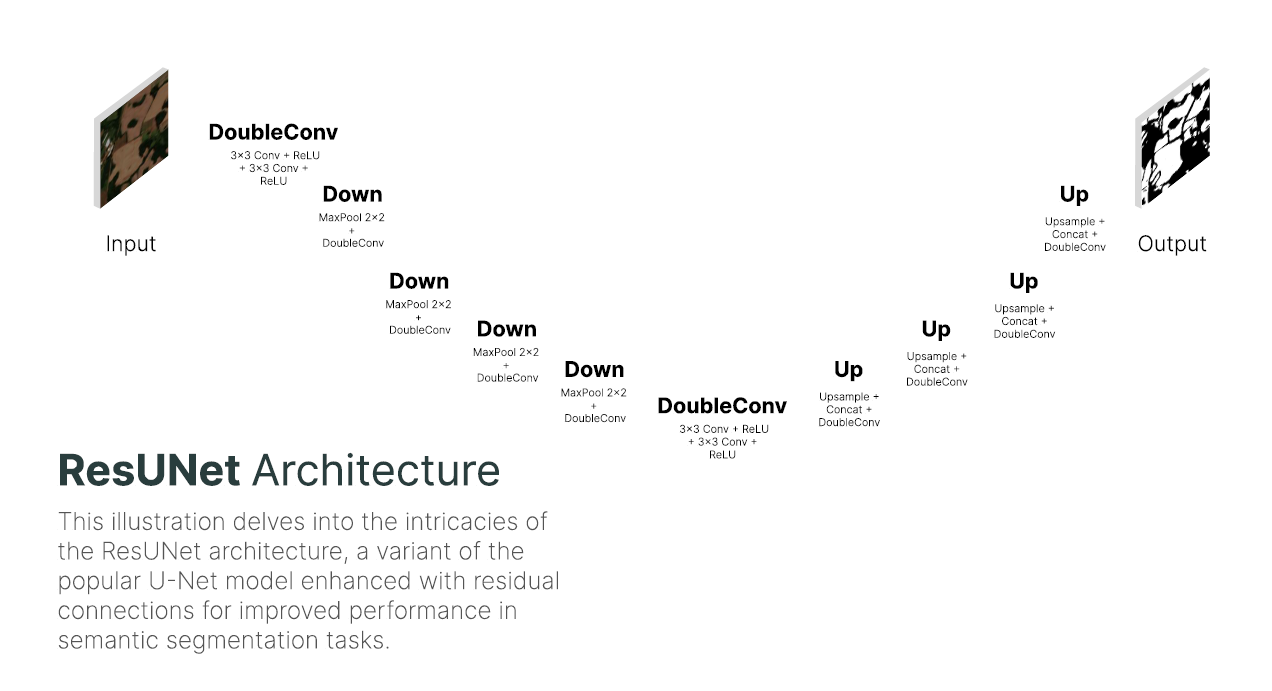

The use of residual blocks helps in building a deeper network without worrying about the problem of vanishing gradient or exploding gradients. It also helps in easy training of the network.
The rich skip connections in the RESUNET helps in better flow of information between different layers, which helps in better flow of gradients while training  (backpropagation).

## References

https://idiotdeveloper.com/what-is-resunet/#google_vignette

## Pipeline Configuration

Set up the processing pipeline by selecting the desired filters and augmentations. This configuration will determine how the images are processed and enhanced.



In [ ]:
pipeline = ProcessingPipeline()
pipeline.add_augmentations([Rotate(), Translate(), Flip(), BrightnessContrast(), RandomGaussianBlur(), MedianBlur()])

base_masks_path = "/content/drive/MyDrive/Images/Masks"
base_inputs_path = "/content/drive/MyDrive/Images/Input"

image_data_manager = ImageDataManager(base_masks_path, base_inputs_path)

## Visualizing

In [ ]:
Visualizer.visualize_objects(image_data_manager.objects)

## Loading resources as `np.array`

In [ ]:
import numpy as np
import cv2

RAW_IMAGE_SIZE = 1200
CROP_SIZE = 120  # RAW_IMAGE_SIZE // 10
IMAGE_SIZE = (CROP_SIZE, CROP_SIZE)
TEST_SET_SIZE_AS_PERCENTAGE = 0.2
BATCH_SIZE = 1

masks_as_np_array = []
images_as_np_array = []

for key in image_data_manager.objects.keys():
    images = image_data_manager.objects[key]['images']
    mask = image_data_manager.objects[key]['mask']

    filtered_images = []

    for image in images:
        if image.shape[1] == RAW_IMAGE_SIZE:
            filtered_images.append(np.transpose(image, (1, 2, 0)))

    image_data_manager.objects[key]['images'] = filtered_images

    image = filtered_images[-1]
    n_crop = image.shape[0] // CROP_SIZE
    images, masks, coordinates = pipeline.run(image, mask, crop_size=CROP_SIZE, n_crop=n_crop, n_augmented=0)

    masks_as_np_array.extend(masks)
    images_as_np_array.extend(images)

print(f"Loaded {len(images_as_np_array)} images")



## Splitting between train and test data

In [ ]:
# val_samples = int(len(images_as_np_array) * TEST_SET_SIZE_AS_PERCENTAGE)

# train_x = images_as_np_array[:-val_samples]
# train_y = masks_as_np_array[:-val_samples]

# test_x = images_as_np_array[-val_samples:]
# test_y = masks_as_np_array[-val_samples:]

# train_set = get_dataset(
#     batch_size=BATCH_SIZE,
#     img_size=IMAGE_SIZE,
#     input_img_arr=train_x,
#     target_img_arr=train_y,
#     max_dataset_len=2000
# )

# test_set = get_dataset(
#     batch_size=BATCH_SIZE,
#     img_size=IMAGE_SIZE,
#     input_img_arr=test_x,
#     target_img_arr=test_y
# )

# visualize_dataset(train_set, num_samples=5, title='Train Set')
# visualize_dataset(test_set, num_samples=5, title='Test Set')

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class ResUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(ResUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
import torch
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)

        return image, mask

def dice_coefficient(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


# Load a pre-trained version of DeepLabV3, trained on COCO
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = ResUNet(n_channels=3, n_classes=2).to(device)

# Move model to GPU
model = model.to(device)

# Set the model in train mode
model.train()

# Define the preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Split your data into training and testing sets
val_samples = int(len(images_as_np_array) * TEST_SET_SIZE_AS_PERCENTAGE)

train_x = images_as_np_array[:-val_samples]
train_y = masks_as_np_array[:-val_samples]

test_x = images_as_np_array[-val_samples:]
test_y = masks_as_np_array[-val_samples:]


# Create PyTorch Datasets
train_set = CustomDataset(
    images=train_x,
    masks=train_y,
    transform=preprocess
)

test_set = CustomDataset(
    images=test_x,
    masks=test_y,
    transform=preprocess
)

# Create PyTorch DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Set the model in training mode
model.train()

NUM_EPOCHS = 2000

def dice_loss(pred, target, smooth = 1.):
    pred = pred.argmax(dim=1)
    intersection = (pred * target).sum(dim=(1,2))
    union = pred.sum(dim=(1,2)) + target.sum(dim=(1,2))

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice.mean()


losses = []
dice_coeffs = []

# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_dice = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.float().to(device)  # Convert inputs to Float format and move to GPU
        targets = targets.long().to(device)  # Ensure targets are Long format for CrossEntropyLoss and move to GPU

        # Forward pass
        # outputs = model(inputs)['out']
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        d_loss = dice_loss(torch.softmax(outputs, dim=1), targets)
        total_loss = loss + d_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Calculate Dice coefficient
        _, preds = torch.max(outputs, 1)
        dice = dice_coefficient(preds, targets)
        epoch_dice += dice.item()
        epoch_loss += total_loss.item()

    # Print loss and Dice coefficient every epoch
    epoch_loss = epoch_loss / len(train_loader)
    epoch_dice = epoch_dice / len(train_loader)
    losses.append(epoch_loss)
    dice_coeffs.append(epoch_dice)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}, Dice Coefficient: {epoch_dice:.4f}")



In [ ]:
# Plot the loss and Dice coefficient
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dice_coeffs, label='Dice Coefficient')
plt.title('Dice Coefficient during training')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from torchsummary import summary

summary(model, (3, 120, 120))


In [ ]:
coverage = calculate_coverage(preds, targets)
print(f"Coverage: {coverage:.2f}%")

In [ ]:
torch.save(model, '/content/drive/My Drive/model_res_u_net43924938834983498.pth')

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


# Define the transformations: resize to the input size that your model expects, convert to tensor, and normalize to 0-1 range.
transform = transforms.Compose([
    transforms.Resize((120, 120)),  # Resize to the size that your model expects
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to the ImageNet mean and standard deviation
])

# Load your image
img = Image.open("/content/drive/MyDrive/manual/1.png").convert("RGB")  # Convert image to RGB

# Apply the transformations
img_t = transform(img)

# Create a mini-batch
img_t = img_t.unsqueeze(0)  # Add an extra dimension for batch size

# Move tensor to the device where your model is
img_t = img_t.to(device)

# Use your model to predict
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # No need to track gradients
    output = model(img_t)


# Use argmax to get the most likely class for each pixel
_, preds = torch.max(output, dim=1)

# Move predictions to CPU and convert to numpy array
preds = preds.cpu().numpy()

# Plot the prediction
plt.imshow(preds[0], cmap='gray')
plt.show()



In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


# Define the transformations: resize to the input size that your model expects, convert to tensor, and normalize to 0-1 range.
transform = transforms.Compose([
    transforms.Resize((120, 120)),  # Resize to the size that your model expects
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to the ImageNet mean and standard deviation
])

# Load your image
img = Image.open("/content/drive/MyDrive/manual/2.png").convert("RGB")  # Convert image to RGB

# Apply the transformations
img_t = transform(img)

# Create a mini-batch
img_t = img_t.unsqueeze(0)  # Add an extra dimension for batch size

# Move tensor to the device where your model is
img_t = img_t.to(device)

# Use your model to predict
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # No need to track gradients
    output = model(img_t)


# Use argmax to get the most likely class for each pixel
_, preds = torch.max(output, dim=1)

# Move predictions to CPU and convert to numpy array
preds = preds.cpu().numpy()

# Plot the prediction
plt.imshow(preds[0], cmap='gray')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assuming 'model', 'device', 'inputs', and 'targets' are already defined
# Set the model in evaluation mode
model.eval()

# Convert inputs and targets to the appropriate format and move to the device (GPU)
inputs = inputs.float().to(device)
targets = targets.long().to(device)

# Forward pass and get the output
outputs = model(inputs)

# Get the predicted segmentation masks
_, preds = torch.max(outputs, 1)

# Move the inputs, targets, and predictions to CPU for visualization
inputs = inputs.cpu()
targets = targets.cpu()
preds = preds.cpu()

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean

# Denormalize the images
inputs_denorm = denormalize(inputs)

# Plot ten different samples
num_samples = 20
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for i in range(num_samples):
    idx = np.random.randint(0, inputs.size(0))

    # Input image
    axes[i, 0].imshow(inputs_denorm[idx].permute(1, 2, 0).clamp(0, 1))
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(targets[idx], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    # Predicted mask
    axes[i, 2].imshow(preds[idx], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def visualize_data(images, masks, title):
    """Function to visualize images and masks"""
    n = 10  # number of samples to display
    fig, ax = plt.subplots(n, 2, figsize=(10, 20))

    for i in range(n):
        ax[i, 0].imshow(images[i])
        ax[i, 0].set_title(f'{title} Image {i+1}')
        ax[i, 1].imshow(masks[i], cmap='gray')
        ax[i, 1].set_title(f'{title} Mask {i+1}')

    plt.tight_layout()
    plt.show()

# Visualize training images and masks
visualize_data(train_x, train_y, 'Train')

# Visualize testing images and masks
visualize_data(test_x, test_y, 'Test')


In [ ]:
!pip install imagehash -q

In [ ]:
from PIL import Image
import imagehash
import numpy as np

def find_duplicates(train_data, test_data):
    """Find duplicate images in the training and testing sets."""

    # Compute a hash for each image in the training set
    train_hashes = [imagehash.phash(Image.fromarray((img * 255).astype(np.uint8))) for img in train_data]

    # Compute a hash for each image in the testing set
    test_hashes = [imagehash.phash(Image.fromarray((img * 255).astype(np.uint8))) for img in test_data]

    # Find duplicates
    duplicates = [test for test in test_hashes if test in train_hashes]

    return duplicates



duplicates_x = find_duplicates(train_x, test_x)
duplicates_y = find_duplicates(train_y, test_y)

print(f"Duplicate images in train_x and test_x: {len(duplicates_x)}")
print(f"Duplicate masks in train_y and test_y: {len(duplicates_y)}")


## Resource Usage Analysis

### GPU Consumption

In [ ]:
output = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
gpu_power = float(output.decode('utf-8').strip())

print("GPU power consumption: ", gpu_power, " Watts")

In [ ]:
print(f'Training time: {training_time} seconds\n\n')
print(f'Inference time: {inference_time} seconds\n\n')
print(f'Memory usage: {psutil.virtual_memory().used} bytes\n\n')
print(batch_size_scalability)
print("GPU power consumption: ", gpu_power, " Watts")

## Sources

### Tutorials and Guides
- [Keras Tutorial on Image Segmentation with Oxford Pets Dataset](https://keras.io/examples/vision/oxford_pets_image_segmentation/)
- [DataCamp Tutorial: Understanding Cross-Entropy Loss in Machine Learning](https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning)
- [Neptune Blog: Guide to Image Segmentation](https://neptune.ai/blog/image-segmentation)

### Research Papers
- Safarov, Furkat, et al. "Improved agricultural field segmentation in satellite imagery using tl-resunet architecture." Sensors 22.24 (2022): 9784.(https://doi.ieeecomputersociety.org/10.1109/CVPR.2017.195)
